# Quantifying spatial variation 

In [2]:
import numpy as np
import pandas as pd
import glob
import skimage.io
import skimage.morphology
import skimage.segmentation
import skimage.filters
import bokeh.io
import bokeh.plotting
import skimage.feature
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../../../')
import mwc.viz
colors = mwc.viz.set_plotting_style()
%matplotlib inline
bokeh.io.output_notebook()

Loading BokehJS ...

##  The problem

To get at the issue of spatial variation, I took a sample of TetraSpec beads that were immobilized on glass and took a large number of frames where I rastered teh field of view. By tracking one of the bigger globs of beads, I should be able to map out any fringing that is present in the field. 

##  Loading the images

In [110]:
# Define the datadir and load the images. 
data_dir = '../../../data/images/20180207_field_mapping/'
files = np.sort(glob.glob('{0}/*beads_raster_2/Pos*/*.tif'.format(data_dir)))

# Load the images as an imagecollection.
ims = skimage.io.ImageCollection(files, conserve_memory=False)

# Load a representative slide image. 
slide = glob.glob('../../../data/images/20180207_laser_stability/*single_position_1/Pos*/*.tif')
im = skimage.io.ImageCollection(slide)
avg_slide = np.mean(ims, axis=0)
noise = glob.glob('../../../data/images/20180202_artemis_37C_glucose_O2_dilution/*TRITC*camera_noise*/Pos*/*.tif')
noise_im = skimage.io.ImageCollection(noise)
avg_noise =np.mean(noise_im, axis=0)

# Flatten the image.
def flatten(im, slide,noise):
    return ((im - noise) / (slide - noise)) * np.mean(slide - noise)
selem = skimage.morphology.square(3)
filt_ims = np.array([skimage.filters.median(i, selem) for i in ims])
flat_ims = np.array([flatten(im, avg_slide, avg_noise) for im in filt_ims])

# Generate the maximum projection
max_proj = np.max(filt_ims, axis=0)

/Users/gchure/anaconda/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/Users/gchure/anaconda/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 13 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/Users/gchure/anaconda/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


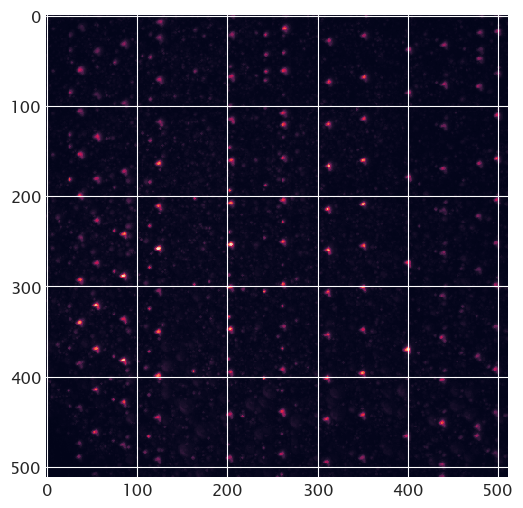

In [112]:
plt.imshow(max_proj)

## Segmentation and tracking

I want to segment the large clump that you can see with the regular pattern (even though I had a few skips). I'll just try thresholding to begin with. 

In [113]:
#Find the location of the peaks.
peaks = skimage.feature.peak_local_max(max_proj, min_distance=30, threshold_rel=0.2, exclude_border=False)

# Plotthem over the image. 
p = mwc.viz.imshow(np.rot90(max_proj), plot_height=800)
for _p in peaks:
    p.circle(_p[0], _p[1], color='white')
bokeh.io.show(p)

There are some other particles being piccked up. I can do some template matching to do a better job of finding the particles. To do so, I need to crop in on a template.

In [114]:
# Create a template image.
template = max_proj[200:300, 200:300][40:65, 50:80]
# template = max_proj[200:300, 200:300][0:20, 0:15]
p = mwc.viz.imshow(template)
bokeh.io.show(p)

In [115]:
matches = skimage.feature.match_template(max_proj, template)
p = mwc.viz.imshow(matches, plot_height=900)
bokeh.io.show(p)

Now I just have to find the maxima in the template matching image. 

(array([  1.50000000e+01,   1.30000000e+02,   5.73000000e+02,
          1.49700000e+03,   3.81200000e+03,   8.63500000e+03,
          1.83690000e+04,   3.65500000e+04,   4.07730000e+04,
          3.11730000e+04,   2.15000000e+04,   1.50140000e+04,
          1.08450000e+04,   8.35400000e+03,   6.46800000e+03,
          5.18200000e+03,   4.08800000e+03,   3.36200000e+03,
          2.66000000e+03,   2.33600000e+03,   1.88900000e+03,
          1.59100000e+03,   1.25500000e+03,   1.13300000e+03,
          9.29000000e+02,   8.59000000e+02,   7.88000000e+02,
          6.44000000e+02,   5.51000000e+02,   5.10000000e+02,
          4.67000000e+02,   3.77000000e+02,   3.99000000e+02,
          3.60000000e+02,   3.29000000e+02,   2.80000000e+02,
          2.36000000e+02,   2.29000000e+02,   2.08000000e+02,
          1.99000000e+02,   2.17000000e+02,   1.80000000e+02,
          1.48000000e+02,   1.41000000e+02,   1.24000000e+02,
          1.14000000e+02,   1.13000000e+02,   6.40000000e+01,
        

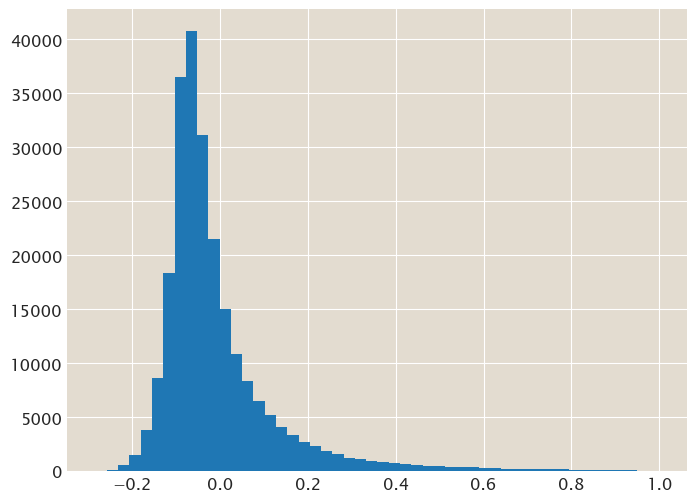

In [116]:
plt.hist(matches.flatten(), bins=50)

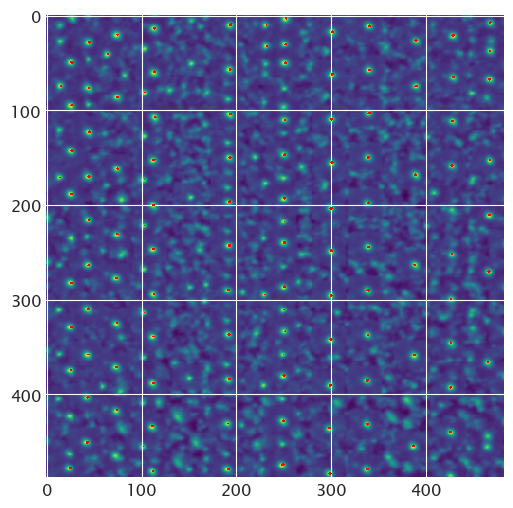

In [117]:
max_hits = skimage.feature.peak_local_max(matches > 0.8, min_distance=25, exclude_border=False, threshold_abs=0.9)
plt.imshow(matches, cmap='viridis')
for p in max_hits:
    plt.plot(p[1], p[0], 'r,')
# p = mwc.viz.imshow(matches>0.8, plot_height=900)
# for _p in max_hits:
#     p.circle(_p[1], _p[0], color='tomato')
# bokeh.io.show(p)

This looks like it is doing a well enough job matching the particles we care about, while ignoring those that aren't our particle of interest. Now we can take these coordinates, draw a 20x20 box around the center of each and sum op the total intensity

In [126]:
# Make a dataframe to store the positions.
df = pd.DataFrame([], columns=['total_intensity', 'area', 'center_x', 'center_y'])

rot_proj = max_proj
im_size = np.shape(rot_proj)
box_radius = 5
mask = np.zeros(im_size).astype(bool)
for x, y in peaks:
#     x += 12
#     y += 10 
    # Determine if the point is close to the edge
    if (x < box_radius):
        x_lower = 0
        x_upper = x + box_radius
    elif (x + box_radius > im_size[0]):
        x_upper = im_size[0]
        x_lower = x - box_radius
    else:
        x_lower = x - box_radius
        x_upper = x + box_radius
        
    if (y < box_radius):
        y_lower = 0
        y_upper = y + box_radius
    elif (y + box_radius > im_size[1]):
        y_upper = im_size[1]
        y_lower = y - box_radius
    else:
        y_lower = y - box_radius
        y_upper = y + box_radius
       
    # Mark the box on the mask.
    slc = np.s_[x_lower:x_upper, y_lower:y_upper]    
    
    # Compute the total and mean intensity
    total_int = np.sum(max_proj[slc])
    mask[slc] = 1.0
    area = (x_upper - x_lower) * (y_upper - y_lower)
    
    # Add to the DataFrame.
    bead_dict = {'total_intensity': total_int, 'area':area, 
                'center_x':x, 'center_y':y}
    df = df.append(bead_dict, ignore_index=True)

In [127]:
max_proj_float = (max_proj - max_proj.min()) / (max_proj.max() - max_proj.min())
copy = np.copy(max_proj_float)
copy[mask] = 1.0
p = mwc.viz.imshow(copy, plot_height=900)
bokeh.io.show(p)

In [128]:
# Rescale the points to maximum
df['rescaled_int'] = df['total_intensity'] 

In [129]:
# Look at the intensity change in either direction. 
p = mwc.viz.boilerplate(plot_width=800, plot_height=800, x_axis_label='pixel number',
                       y_axis_label='intensity relative to maximum')
sorted_x = df.sort_values('center_x')
sorted_y = df.sort_values('center_y')
# p.circle(sorted_x['center_x'], sorted_x['rescaled_int'],  color='dodgerblue', legend='x dimension')
p.line(sorted_x['center_x'], sorted_x['rescaled_int'],  color='dodgerblue', legend='x dimension')
# p.circle(sorted_y['center_y'], sorted_y['rescaled_int'],  color='tomato', legend='y dimension')
p.line(sorted_y['center_y'], sorted_y['rescaled_int'],  color='tomato', legend='y dimension')
bokeh.io.show(p)

Now let's look if we compute the straightline distance between particles and sort them. 

In [130]:
import tqdm

In [131]:
dist_df = pd.DataFrame([], columns=['distance', 'intensity_1', 'intensity_2', 
                                    'sq_diff', 'summed'])
for i in tqdm.tqdm(range(0, int(len(df) / 2))):
    for j in range(int(len(df) / 2), len(df)):
        if i != j:
            # Separate the beads
            bead_1 = df.iloc[i]
            bead_2 = df.iloc[j]
            int_1, int_2 = [bead_1['total_intensity'], bead_2['total_intensity']]
            
            # Sort the x and y distances
            x_centers = np.sort(np.array([bead_1['center_x'],bead_2['center_x']]))
            y_centers = np.sort(np.array([bead_1['center_y'],bead_2['center_y']]))
            
            # Distances
            dist = np.sqrt((np.diff(x_centers)**2 + np.diff(y_centers)**2))[0]
            dist_df = dist_df.append({'distance':dist, 'intensity_1':int_1, 'intensity_2':int_2,
                                     'sq_diff': (int_1 - int_2)**2, 'summed': int_1 + int_2},
                                    ignore_index=True) 

100%|██████████| 87/87 [00:09<00:00,  8.76it/s]


In [132]:
# Sort the data by the distances.
sorted_dists = dist_df.sort_values(['distance'])

# Make the ecdf of distance and fluctuation.
y = np.arange(len(dist_df)) / len(dist_df)
p = mwc.viz.boilerplate(x_axis_label='distance [µm]',
                       y_axis_label='cumulative distribution')
p.circle(sorted_dists['distance'] *0.163, y)
bokeh.io.show(p)

If the field were "perfectly" flat, all fluctuations should be very close to 0.5. Let's compute those fluctuations. 

In [135]:
# Compute the ratios.
ratios = dist_df['intensity_1'] / dist_df['intensity_2']
# Generate the cdf.
x, y = np.sort(ratios), np.arange(len(ratios)) / len(ratios)

p = mwc.viz.boilerplate(x_axis_label='I1 /(I1 + I2)',
                       y_axis_label='cumulative distribution')
p.circle(x, y)
bokeh.io.show(p)

In [147]:
p = mwc.viz.boilerplate(x_axis_label='I_1 + I_2', y_axis_label='squared fluctuation',
                       x_axis_type='log', y_axis_type='log', plot_width=800)
close = dist_df[dist_df['distance'] * 0.163 < 20]
p.circle(close['summed'], close['sq_diff'])
bokeh.io.show(p)

In [143]:
close


Empty DataFrame
Columns: [distance, intensity_1, intensity_2, sq_diff, summed]
Index: []